<a href="https://colab.research.google.com/github/sjpark08/math-science/blob/main/CFD_SurrogateModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf # for neural network models
print(tf.__version__)

2.19.0


Kaggle Setup

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jjunzzimin","key":"90a1afea9a069682b552d5717440e816"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list

ref                                                       title                                              size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                                  Heart Disease                                      3491  2025-12-11 15:29:14.327000           2114        112  1.0              
suvidyasonawane/student-performance-dataset               Student Performance Dataset                       81679  2025-12-25 05:27:51.453000              0         31  1.0              
wardabilal/spotify-global-music-dataset-20092025          Spotify Global Music Dataset (2009–2025)        1289021  2025-11-11 09:43:05.933000          16387        449  1.0              
neurocipher/student-performance                           Student

Data Set downloading

In [ ]:
!kaggle datasets download -d victorienmichel/deeplearwing
!unzip deeplearning.zip

Dataset URL: https://www.kaggle.com/datasets/victorienmichel/deeplearwing
License(s): MIT
  0% 0.00/18.3M [00:00<?, ?B/s]
100% 18.3M/18.3M [00:00<00:00, 1.72GB/s]
unzip:  cannot find or open deeplearning.zip, deeplearning.zip.zip or deeplearning.zip.ZIP.


In [ ]:
!unzip deeplearwing.zip


Archive:  deeplearwing.zip
  inflating: DeepLearWing.csv        


In [ ]:
!ls


DeepLearWing.csv  deeplearwing.zip  sample_data


In [ ]:
df = pd.read_csv("DeepLearWing.csv")

In [ ]:
df.head()

,name,angle,reynolds,x_coords,y_coords,cd,cl,cm
0,2032c,-8.75,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.09761,-0.1581,-0.0262
1,2032c,-8.50,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.09468,-0.1536,-0.0262
2,2032c,-8.25,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.10671,-0.2407,-0.0219
3,2032c,-8.00,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.10247,-0.2303,-0.0213
4,2032c,-7.75,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.09947,-0.2229,-0.0215


In [ ]:
df.columns

Index(['name', 'angle', 'reynolds', 'x_coords', 'y_coords', 'cd', 'cl', 'cm'], dtype='object')

In [ ]:
df[["x_coords", "y_coords"]].iloc[0]

,0
x_coords,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...
y_coords,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...


In [ ]:
type(df.loc[0, "x_coords"]), repr(df.loc[0, "x_coords"])[:120]


(str,
 "'1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 0.15 0.1 0.075 0.05 0.025 0.0125 0.0 0.0125 0.025 0.05 0.075 0.1 0.15 0.2")

In [ ]:

def parse_coords(s):
    return np.array(s.split(), dtype=np.float32)

In [ ]:
x0 = parse_coords(df.loc[0, "x_coords"])
y0 = parse_coords(df.loc[0, "y_coords"])

print(type(x0))
print(x0[:5])
print(len(x0), len(y0))

<class 'numpy.ndarray'>
[1.   0.95 0.9  0.8  0.7 ]
35 35


In [ ]:
lengths = df["x_coords"].apply(lambda s: len(s.split()))
lengths.describe()


,x_coords
count,819191.000000
mean,64.138559
std,36.110167
min,24.000000
25%,33.000000
50%,61.000000
75%,79.000000
max,260.000000


In [ ]:
geom0 = np.stack([x0, y0], axis=1)
print(geom0.shape)

(35, 2)


Problem emerged: dimension error. Trying to fix using interpolation N = 61

In [ ]:
def parse_coords(s):
    return np.array(s.split(), dtype=np.float32)

def resample_xy(x, y, n):
    x = np.asarray(x, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)

    t_old = np.linspace(0.0, 1.0, len(x), dtype=np.float32)
    t_new = np.linspace(0.0, 1.0, n, dtype=np.float32)

    x_new = np.interp(t_new, t_old, x)
    y_new = np.interp(t_new, t_old, y)

    return x_new, y_new

Median of the size of the data coord. was 61.

In [ ]:
N = 61

In [ ]:
num_samples = len(df)
geom = np.zeros((num_samples, 2 * N), dtype=np.float32)

for i in range(num_samples):
    x = parse_coords(df.iloc[i]["x_coords"])
    y = parse_coords(df.iloc[i]["y_coords"])

    xr, yr = resample_xy(x, y, n=N)

    geom[i, 0::2] = xr
    geom[i, 1::2] = yr

print("Geometry matrix shape:", geom.shape)

Geometry matrix shape: (819191, 122)


In [ ]:
angles = df["angle"].to_numpy(dtype=np.float32).reshape(-1, 1)
re_log = np.log10(df["reynolds"].to_numpy(dtype=np.float32)).reshape(-1, 1)

X = np.hstack([angles, re_log, geom])
Y = df[["cl", "cd"]].to_numpy(dtype=np.float32)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (819191, 124)
Y shape: (819191, 2)


Testing the format of the input and output set

In [ ]:
X[0]

array([-8.75000000e+00,  5.30103016e+00,  1.00000000e+00,  1.59999996e-03,
        9.71666634e-01,  7.72000058e-03,  9.43333328e-01,  1.38000008e-02,
        9.14999962e-01,  1.97500009e-02,  8.73333335e-01,  2.82066688e-02,
        8.16666663e-01,  3.94833349e-02,  7.59999990e-01,  5.00800014e-02,
        7.03333318e-01,  6.03933334e-02,  6.46666646e-01,  6.95866719e-02,
        5.90000033e-01,  7.84400031e-02,  5.33333361e-01,  8.60333294e-02,
        4.76666659e-01,  9.27633271e-02,  4.20000017e-01,  9.82600003e-02,
        3.63333344e-01,  1.01886667e-01,  3.06666672e-01,  1.04493335e-01,
        2.75000006e-01,  1.04600005e-01,  2.46666670e-01,  1.04193337e-01,
        2.18333364e-01,  1.02436669e-01,  1.89999998e-01,  9.97200012e-02,
        1.61666691e-01,  9.52433422e-02,  1.33333340e-01,  8.82666707e-02,
        1.05000027e-01,  7.95400068e-02,  8.83333385e-02,  7.25866705e-02,
        7.41666853e-02,  6.58966750e-02,  6.00000024e-02,  5.73399998e-02,
        4.58333455e-02,  

In [ ]:
angle_0 = X[0, 0]
re_log_0 = X[0, 1]
geom_0 = X[0, 2:]           # length = 2*N

x_coords_0 = geom_0[0::2]   # even indices
y_coords_0 = geom_0[1::2]   # odd indices

print("Angle:", angle_0)
print("log10(Re):", re_log_0)
print("Geometry shape:", geom_0.shape)
print("x_coords shape:", x_coords_0.shape)
print("y_coords shape:", y_coords_0.shape)

Angle: -8.75
log10(Re): 5.30103
Geometry shape: (122,)
x_coords shape: (61,)
y_coords shape: (61,)


In [ ]:
import matplotlib.pyplot as plt

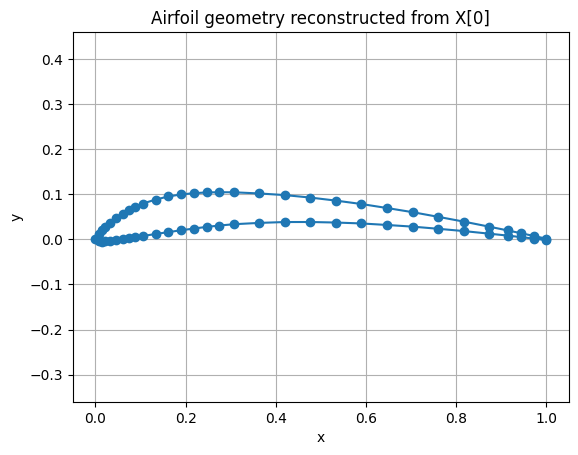

In [ ]:

plt.figure()
plt.plot(x_coords_0, y_coords_0, marker="o")
plt.axis("equal")
plt.grid(True)
plt.title("Airfoil geometry reconstructed from X[0]")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


Summary
1. Kaggle Setup
2. Data Set download
3. Data Set formatting
4. Testing re-formatted data set

**Train-Test split**

Decided to **not**  use random TT split. In order to make this model being capable of calculating aerodynamic coefficients, TT split should be based on names

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
"""
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=0
)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("Y_train:", Y_train.shape)
print("Y_test :", Y_test.shape)
"""

'\nX_train, X_test, Y_train, Y_test = train_test_split(\n    X, Y, test_size=0.3, random_state=0\n)\n\nprint("X_train:", X_train.shape)\nprint("X_test :", X_test.shape)\nprint("Y_train:", Y_train.shape)\nprint("Y_test :", Y_test.shape)\n'

TT split based on names

In [ ]:
names = df["name"].values
unique_names = np.unique(names)

print("Total unique airfoils:", len(unique_names))

Total unique airfoils: 1630


In [ ]:
rng = np.random.default_rng(seed=0)   # reproducible
rng.shuffle(unique_names)

split_idx = int(0.7 * len(unique_names))

train_names = set(unique_names[:split_idx])
test_names  = set(unique_names[split_idx:])


In [ ]:
train_mask = np.array([name in train_names for name in names])
test_mask  = np.array([name in test_names  for name in names])


In [ ]:
assert not np.any(train_mask & test_mask)
assert train_mask.sum() + test_mask.sum() == len(df)


In [ ]:
X_train = X[train_mask]
Y_train = Y[train_mask]

X_test  = X[test_mask]
Y_test  = Y[test_mask]

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("Y_train:", Y_train.shape)
print("Y_test :", Y_test.shape)


X_train: (574643, 124)
X_test : (244548, 124)
Y_train: (574643, 2)
Y_test : (244548, 2)


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

ML model **(Arch. 1)**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = keras.Sequential([
    layers.Input(shape=(124,)),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.2),

    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.2),

    layers.Dense(64, activation="relu"),
    layers.Dense(2)
])

In [ ]:
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)


In [ ]:
history = model.fit(
    X_train_scaled, Y_train,
    validation_data=(X_test_scaled, Y_test),
    epochs=30,
    batch_size=1024
)

Epoch 1/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.1140 - mean_absolute_error: 0.2080 - val_loss: 0.0139 - val_mean_absolute_error: 0.0721
Epoch 2/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0169 - mean_absolute_error: 0.0846 - val_loss: 0.0105 - val_mean_absolute_error: 0.0594
Epoch 3/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0128 - mean_absolute_error: 0.0707 - val_loss: 0.0083 - val_mean_absolute_error: 0.0511
Epoch 4/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0107 - mean_absolute_error: 0.0633 - val_loss: 0.0082 - val_mean_absolute_error: 0.0509
Epoch 5/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0095 - mean_absolute_error: 0.0590 - val_loss: 0.0072 - val_mean_absolute_error: 0.0471
Epoch 6/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0088 - mean_absolute_error: 0.0563 - val_loss: 0.0067 - val_mean_absolute_error: 0.0450
Epoch 7/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0083 - mean_absolute_error: 0.0544 -

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save("/content/drive/MyDrive/airfoil_surrogate_model.keras")


Mounted at /content/drive


/content/drive/MyDrive/airfoil_surrogate_model.keras

In [ ]:
load_model("/content/drive/MyDrive/airfoil_surrogate_model.keras")

NameError: name 'load_model' is not defined

In [ ]:
x_one = X_test_scaled[0:1]   # shape (1, 124)

y_pred = model.predict(x_one)

print("Predicted [CL, CD]:", y_pred)
print("True [CL, CD]:     ", Y_test[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
Predicted [CL, CD]: [[-0.28340083  0.09400457]]
True [CL, CD]:      [-0.1581   0.09761]


ML model **(Arch. 2)**

Two-branch network


In [ ]:
X_train_cond = X_train[:, :2]
X_train_geom = X_train[:, 2:].reshape(-1, 61, 2)

X_test_cond  = X_test[:, :2]
X_test_geom  = X_test[:, 2:].reshape(-1, 61, 2)

In [ ]:

# ----- Condition branch -----
cond_input = layers.Input(shape=(2,), name="cond_input")
c = layers.Dense(16, activation="relu")(cond_input)
c = layers.Dense(8, activation="relu")(c)

# ----- Geometry branch -----
geom_input = layers.Input(shape=(61, 2), name="geom_input")

g = layers.Conv1D(64, 3, padding="same", activation="relu")(geom_input)
g = layers.Conv1D(64, 3, padding="same", activation="relu")(g)
g = layers.MaxPooling1D(2)(g)

g = layers.Conv1D(32, 3, padding="same", activation="relu")(g)
g = layers.Conv1D(32, 3, padding="same", activation="relu")(g)
g = layers.MaxPooling1D(2)(g)

g = layers.Conv1D(16, 3, padding="same", activation="relu")(g)
g = layers.GlobalAveragePooling1D()(g)

g = layers.Dense(64, activation="relu")(g)

# ----- Fusion head -----
x = layers.Concatenate()([g, c])
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation="relu")(x)
out = layers.Dense(2)(x)

model2 = keras.Model(
    inputs=[geom_input, cond_input],
    outputs=out
)


In [ ]:
model2.compile(
    optimizer="adam",
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    mode="min",
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_mae",
    mode="min",
    factor=0.5,
    patience=5,
    min_lr=1e-6
)


In [ ]:
history = model2.fit(
    {"geom_input": X_train_geom, "cond_input": X_train_cond},
    Y_train,
    epochs=40,
    batch_size=1024,
    verbose=1
)

test_loss, test_mae = model2.evaluate(
    {"geom_input": X_test_geom, "cond_input": X_test_cond},
    Y_test,
    verbose=1
)

print("Test MAE:", test_mae)

Epoch 1/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0045 - mean_absolute_error: 0.0378
Epoch 2/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0045 - mean_absolute_error: 0.0377
Epoch 3/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0045 - mean_absolute_error: 0.0375
Epoch 4/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0044 - mean_absolute_error: 0.0375
Epoch 5/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0044 - mean_absolute_error: 0.0370
Epoch 6/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0044 - mean_absolute_error: 0.0370
Epoch 7/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0044 - mean_absolute_error: 0.0374
Epoch 8/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0043 - mean_absolute_error: 0.0369
Epoch 9/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0043 - mean_absolute_error: 0.0369
Epoch 10/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0044 - mean_absolute_error: 0.0372
Epoch 11/40
562/56

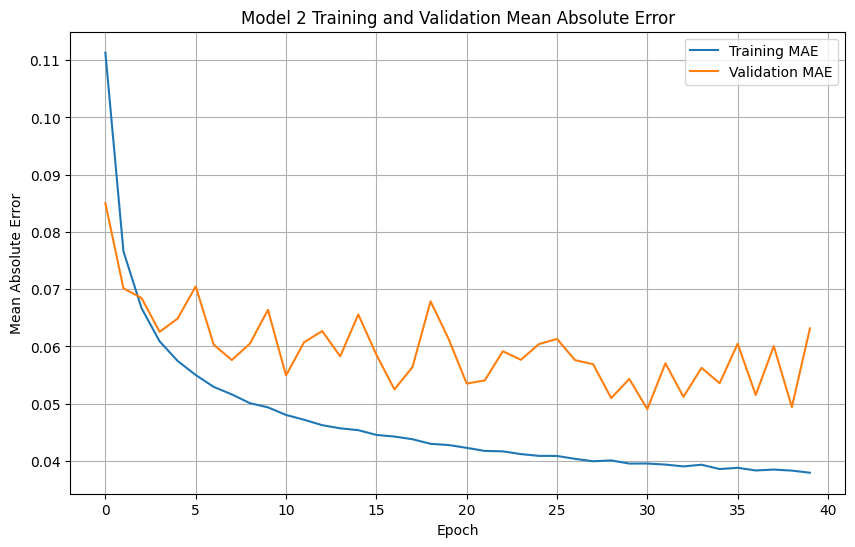

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model 2 Training and Validation Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()